In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.0 MB/s 
     |████████████████████████████████| 596 kB 29.0 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
     |████████████████████████████████| 86 kB 3.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import files
files.upload()         
import pandas as pd
train_ori = pd.read_csv("fixed_train.csv")
valid_ori = pd.read_csv("fixed_valid.csv")
test_ori = pd.read_csv("fixed_test.csv")
train_ori.head()

Saving fixed_test.csv to fixed_test.csv
Saving fixed_train.csv to fixed_train.csv
Saving fixed_valid.csv to fixed_valid.csv


,conv_id,utterance_idx,prompt,utterance,label
0,hit:0_conv:1,1,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...,13
1,hit:0_conv:1,2,I remember going to the fireworks with my best...,Was this a friend you were in love with_comma_...,13
2,hit:0_conv:1,3,I remember going to the fireworks with my best...,This was a best friend. I miss her.,13
3,hit:0_conv:1,4,I remember going to the fireworks with my best...,Where has she gone?,13
4,hit:0_conv:1,5,I remember going to the fireworks with my best...,We no longer talk.,13


# Data Integration

In [3]:
train = train_ori.groupby(['conv_id', 'prompt', 'label'], as_index=False).agg({
    'utterance': lambda u: ' '.join(u)
    }).reindex(columns=['conv_id', 'prompt', 'utterance', 'label'])

valid = valid_ori.groupby(['conv_id', 'prompt', 'label'], as_index=False).agg({
    'utterance': lambda u: ' '.join(u)
    }).reindex(columns=['conv_id', 'prompt', 'utterance', 'label'])

test = test_ori.groupby(['conv_id', 'prompt'], as_index=False).agg({
    'utterance': lambda u: ' '.join(u)
    }).reindex(columns=['conv_id', 'prompt', 'utterance'])

train

,conv_id,prompt,utterance,label
0,hit:0_conv:1,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...,13
1,hit:10000_conv:20000,My girlfriend got me a toad today! I was so sh...,My girlfriend got me a pet toad today! Do you ...,9
2,hit:10000_conv:20001,I really like the new paint job on my house.,I really like the new paint job on my house. T...,12
3,hit:10001_conv:20002,I went to the skating rink all by myself today...,I went to the skating rink all by myself today...,21
4,hit:10002_conv:20004,I was walking on the road. I saw beggar and i ...,I was walking on the road. I saw a beggar and ...,10
...,...,...,...,...
19528,hit:9999_conv:19999,I went skydiving for the first time recently. ...,So I went skydiving for the first time the oth...,24
19529,hit:999_conv:1998,I recently took the Law School Admissions Test.,I believe I did rather well on my Law School A...,23
19530,hit:999_conv:1999,I was shocked when Lebron left the Cavs again,I was shocked when Lebron left the cavs again!...,14
19531,hit:99_conv:198,I am ashamed when I cheated on the test.,I cheated on a test. I am very ashamed. oh no ...,10


In [4]:
print("# original training samples：", len(train_ori))
print("# original validation samples：", len(valid_ori))
print("# original test samples：", len(test_ori))
print("-------------------------------------")
print("# training samples：", len(train))
print("# validation samples：", len(valid))
print("# test samples：", len(test))

# original training samples： 84169
# original validation samples： 12078
# original test samples： 10973
-------------------------------------
# training samples： 19533
# validation samples： 2770
# test samples： 2547


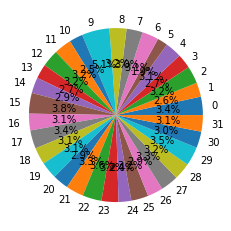

In [5]:
import matplotlib.pyplot as plt
labels = [x for x in range(32)]
num_labels = [sum(train.label == x) for  x in range(32)]
plt.pie(num_labels, labels=labels, autopct='%1.1f%%')
plt.show()

In [6]:
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset
from IPython.display import clear_output
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EmotionDataset(Dataset):
    def __init__(self, mode, df, tokenizer):
        assert mode in ['train', 'valid', 'test']
        self.mode = mode
        self.df = df.fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == 'test':
            prompt, utterance = self.df.iloc[idx, 1:3].values
            label_tensor = None
        else:
            prompt, utterance, label = self.df.iloc[idx, 1:].values
            label_tensor = torch.tensor(label)
            
        # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        #prompt = prompt.replace("_comma_", ",")
        #text =   prompt 
        #utterance = utterance.replace("_comma_", ",")
        #text += utterance 

        word_pieces = self.tokenizer.encode_plus(prompt.replace("_comma_", ",")+utterance.replace("_comma_", ","))
        #print(word_pieces["input_ids"])
        # 將整個 token 序列轉換成索引序列
        ids = word_pieces["input_ids"]
        tokens_tensor = torch.tensor(ids)[:512]
        
        # 將第一句包含 [SEP] 的 token 位置設為 0
        segments_tensor = torch.tensor(
            [0] * len(tokens_tensor),
            dtype=torch.long
        )[:512]
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# # Initialize Datasets for Transformation
# trainset = EmotionDataset('train', train, True, tokenizer=tokenizer)
# validset = EmotionDataset('valid', valid, True, tokenizer=tokenizer)

# print('trainset size:', trainset.__len__())
# print('validset size:', validset.__len__())

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [7]:
# Initialize Datasets for Transformation
trainset = EmotionDataset('train', train, tokenizer=tokenizer)
validset = EmotionDataset('valid', valid, tokenizer=tokenizer)

# print('trainset size:', trainset.__len__())
# print('validset size:', validset.__len__())

# 選擇第一個樣本
sample_idx = 0

# 將原始文本拿出做比較
prompt, utterance, label = trainset.df.iloc[sample_idx, 1:].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

# 渲染前後差異，毫無反應就是個 print。可以直接看輸出結果
print(f"""[Original Statement]
prompt:     {prompt}
utterance:  {utterance}
label:      {label}

tokens: {tokens}

--------------------

[Tensors]
tokens_tensor:
    {tokens_tensor}

segments_tensor:
    {segments_tensor}

label_tensor:
    {label_tensor}

--------------------

[Recovered Text]
{combined_text}
""")

[Original Statement]
prompt:     I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.
utterance:  I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world. Was this a friend you were in love with_comma_ or just a best friend? This was a best friend. I miss her. Where has she gone? We no longer talk. Oh was this something that happened because of an argument?
label:      13

tokens: ['<s>', 'I', 'Ġremember', 'Ġgoing', 'Ġto', 'Ġthe', 'Ġfireworks', 'Ġwith', 'Ġmy', 'Ġbest', 'Ġfriend', '.', 'ĠThere', 'Ġwas', 'Ġa', 'Ġlot', 'Ġof', 'Ġpeople', ',', 'Ġbut', 'Ġit', 'Ġonly', 'Ġfelt', 'Ġlike', 'Ġus', 'Ġin', 'Ġthe', 'Ġworld', '.', 'I', 'Ġremember', 'Ġgoing', 'Ġto', 'Ġsee', 'Ġthe', 'Ġfireworks', 'Ġwith', 'Ġmy', 'Ġbest', 'Ġfriend', '.', 'ĠIt', 'Ġwas', 'Ġthe', 'Ġfirst', 'Ġtime', 'Ġwe', 'Ġe

In [8]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# create_mini_batch 的參數 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    # 先製作一條長度和 token_tensors 一樣的 0 張量
    # 接著將不為 zero padding 的位置設為1
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 BATCH_SIZE 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
trainloader = DataLoader(trainset, batch_size=16, 
                         collate_fn=create_mini_batch)

validloader = DataLoader(validset, batch_size=16, 
                         collate_fn=create_mini_batch)

In [9]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([16, 119]) 
tensor([[   0,  100, 2145,  ..., 4795,  116,    2],
        [   0, 2387, 6096,  ...,    0,    0,    0],
        [   0,  100,  269,  ...,    0,    0,    0],
        ...,
        [   0,  100,  437,  ...,    0,    0,    0],
        [   0,  100,  524,  ...,    0,    0,    0],
        [   0,  100,  269,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape = torch.Size([16, 119])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([16, 119])
tensor([[0, 1, 1,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape     

In [10]:
from transformers import RobertaForSequenceClassification
from IPython.display import clear_output

PRETRAINED_MODEL_NAME = "roberta-base"
NUM_LABELS = 32

model = RobertaForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "roberta":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
roberta:embeddings
roberta:encoder
classifier       RobertaClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=32, bias=True)
)


In [11]:
# model.config

In [12]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in tqdm(dataloader):
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            if not compute_acc:
                # 只是單純要回傳預測值的話，不用計算準確度也不用紀錄 loss
                tokens_tensors, segments_tensors, masks_tensors = data[:3]
                outputs = model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors)
                logits = outputs[0]
                _, pred = torch.max(logits.data, 1)
            else:
                # 否則就要計算 loss，這邊有一個小細節是 model 如果有吃 label 的話，
                # output[0]會變成是 loss，沒有吃 label 時 output[0] 會是 logits
                tokens_tensors, segments_tensors, masks_tensors, labels = data[:4]
                outputs = model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors,
                                labels=labels)
                loss = outputs[0]
                logits = outputs[1]
                _, pred = torch.max(logits.data, 1)
                running_loss += loss.item()
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        loss = running_loss / total
        return predictions, acc, loss
    
    return predictions

In [13]:
%%time
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
EPOCHS = 3

for epoch in range(EPOCHS):
    running_loss = 0.0
    for data in tqdm(trainloader):
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        # 紀錄當前 batch loss
        running_loss += loss.item()

    # 計算分類準確率
    _, train_acc, train_loss = get_predictions(model, trainloader, compute_acc=True)
    _, valid_acc, valid_loss = get_predictions(model, validloader, compute_acc=True)
    
    print('[epoch %d] train loss: %.3f, train acc: %.3f, valid loss: %.3f, valid acc: %.3f' %
          (epoch + 1, train_loss, train_acc, valid_loss, valid_acc))
#import os
#os.environ['CUDA_LAUNCH_BLOCKING']="1"

device: cuda:0


  0%|          | 0/1221 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1221 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

[epoch 1] train loss: 0.077, train acc: 0.626, valid loss: 0.084, valid acc: 0.588


  0%|          | 0/1221 [00:00<?, ?it/s]

  0%|          | 0/1221 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

[epoch 2] train loss: 0.062, train acc: 0.685, valid loss: 0.076, valid acc: 0.621


  0%|          | 0/1221 [00:00<?, ?it/s]

  0%|          | 0/1221 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

[epoch 3] train loss: 0.052, train acc: 0.727, valid loss: 0.076, valid acc: 0.611
CPU times: user 31min 53s, sys: 10min 32s, total: 42min 26s
Wall time: 42min 32s


In [14]:
torch.save(model.state_dict(), 'checkpoint.pth')
print('Model saved!')

Model saved!


# Test

In [15]:
model = RobertaForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
model.load_state_dict(torch.load("checkpoint.pth"))
model.to(device)
model.eval()
clear_output()

In [16]:
testset = EmotionDataset("test", test, tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=16, collate_fn=create_mini_batch)

predictions = get_predictions(model, testloader)
predictions = predictions.cpu().numpy()

  0%|          | 0/160 [00:00<?, ?it/s]

In [17]:
prediction_df = pd.DataFrame({'conv_id': test.conv_id, 'pred': predictions})
reverted_df = test_ori.merge(prediction_df)

In [18]:
reverted_df

,conv_id,utterance_idx,prompt,utterance,pred
0,hit:0_conv:0,1,I felt guilty when I was driving home one nigh...,Yeah about 10 years ago I had a horrifying exp...,25
1,hit:0_conv:0,2,I felt guilty when I was driving home one nigh...,Did you suffer any injuries?,25
2,hit:0_conv:0,3,I felt guilty when I was driving home one nigh...,No I wasn't hit. It turned out they were drunk...,25
3,hit:0_conv:0,4,I felt guilty when I was driving home one nigh...,Why did you feel guilty? People really shouldn...,25
4,hit:0_conv:0,5,I felt guilty when I was driving home one nigh...,I don't know I was new to driving and hadn't e...,25
...,...,...,...,...,...
10968,hit:12416_conv:24832,4,I saw a huge cockroach outside my house today....,I live in Texas to so i know those feels,8
10969,hit:12423_conv:24847,1,I have a big test on Monday. I am so nervous_c...,I have a big test on Monday_comma_ I am so ner...,18
10970,hit:12423_conv:24847,2,I have a big test on Monday. I am so nervous_c...,What is the test on?,18
10971,hit:12423_conv:24847,3,I have a big test on Monday. I am so nervous_c...,It's for my Chemistry class. I haven't slept m...,18


In [19]:
# textfile = open('prediction.txt', 'w')
# textfile.write(',pred' + '\n')
# for Id, pred in enumerate(predictions):
#     textfile.write('{},{}\n'.format(Id, pred))
# textfile.close()

In [20]:
my_submission = pd.DataFrame({'': test_ori.index, 'pred': reverted_df.pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [21]:
my_submission

,,pred
0,0,25
1,1,25
2,2,25
3,3,25
4,4,25
...,...,...
10968,10968,8
10969,10969,18
10970,10970,18
10971,10971,18


In [22]:
from google.colab import files
files.download('checkpoint.pth')
# files.download('prediction.txt')
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>